In [ ]:
!mkdir frames

In [ ]:
import cv2
import numpy as np

# Read the image
image = cv2.imread ("/content/melanoma.jpg")

# Blur the image using GaussianBlur function
image_blur = cv2.GaussianBlur (image, (5, 5), 0)

# Subtract the blurred image from the original image
image_diff = cv2.subtract (image, image_blur)

# Add the difference image to the original image
image_sharp = cv2.add (image, image_diff)

cv2.imwrite('test1.jpg',image_sharp)


True

In [ ]:
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet

# Read the image
image = cv2.imread ("/content/melanoma.jpg")

# Apply Gaussian filtering using OpenCV
image_blur = cv2.GaussianBlur (image, (5, 5), 0)

# Apply wavelet denoising using scikit-image
image_denoise = denoise_wavelet (image, multichannel=True)

cv2.imwrite('test2.jpg',image_denoise)

In [ ]:
import cv2
import numpy as np

# Read the image
image = cv2.imread ("/content/melanoma.jpg")

kernel = np.ones((3,3),np.float32)/9
image_denoise = cv2.filter2D(image,-1,kernel)

cv2.imwrite('test3.jpg',image_denoise)


True

100%|██████████| 50/50 [02:22<00:00,  2.86s/it]


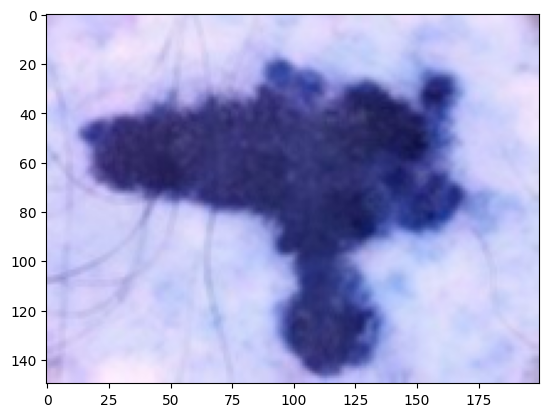

In [ ]:
import cv2
import numpy as np
import time
import math
import tqdm
from matplotlib import pyplot as plt
from skimage import filters
from skimage import io, color, img_as_float


def save_image(img, points, path):
    points = np.array(points, np.int32)
    points = np.roll(points, 1, axis=1)
    points = points.reshape((-1, 1, 2))
    copy = img.copy()
    cv2.polylines(copy, [points], True, (200, 200, 200), thickness=3)
    cv2.imwrite(path, copy)


def get_initial_points(center, radius, num_of_points):
    points = np.zeros((num_of_points, 2), dtype=np.int64)
    for i in range(num_of_points):
        theta = float(i) * (2 * np.pi) / num_of_points
        x = center[0] + 1.75*radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        points[i] = [y, x]
    return points


def get_gradient(img):
    gradient = cv2.Canny(img, 150, 250).astype(float)
    gradient = filters.gaussian(gradient, 7)
    gradient /= gradient.max()
    return gradient




def get_first_derivative_mean(points):
    prev_indexes = np.roll(points, 1, axis=0)
    first_derivative = points - prev_indexes
    first_derivative = np.sqrt(first_derivative[:, 0] ** 2 + first_derivative[:, 1] ** 2)
    return np.mean(first_derivative, axis=0)


def find_best_neighbour(points, point, delta_list, current, viterbi_mat, _lambda, neighbour_size, first_derivative):
    min_value = np.inf
    min_index = 0
    for last_neighbour in range(neighbour_size):
        previous = points[point - 1] + delta_list[last_neighbour]
        e = calculate_lambda_term(viterbi_mat, point, last_neighbour, _lambda, current, previous, first_derivative)
        if e < min_value:
            min_value = e
            min_index = last_neighbour
    return min_value, min_index


def calculate_lambda_term(viterbi_mat, point, last_neighbour, _lambda, current, previous, first_derivative):
    e = viterbi_mat[last_neighbour, point - 1, 0]
    e +=_lambda * ((current[0]-previous[0]) ** 2+(current[1]-previous[1]) ** 2 - first_derivative) ** 2
    return e


def update_points(points, number_of_points, viterbi_mat, delta_list):
    min_index = viterbi_mat[:, number_of_points - 1, 0].argmin()
    min_index = int(min_index)
    points[0] = points[number_of_points - 1] + delta_list[min_index]
    for point in range(number_of_points - 1):
        current = number_of_points - point - 1
        min_index = viterbi_mat[int(min_index), current, 1]
        points[current] = points[current - 1] + delta_list[int(min_index)]
    return points


def active_contour(number_of_iterations, number_of_points, points, neighbour_len, img_gr, delta_list, img_o, _lambda, gamma):
    neighbour_size = neighbour_len ** 2
    for iteration in tqdm.tqdm(range(number_of_iterations)):
        viterbi_mat = np.zeros((neighbour_size, number_of_points, 2))
        first_derivative = get_first_derivative_mean(points)

        for point in range(number_of_points):
            for neighbour in range(neighbour_size):
                current = points[point] + delta_list[neighbour]
                _lambda_value, min_index = find_best_neighbour(points, point, delta_list, current, viterbi_mat, _lambda,
                                                             neighbour_size, first_derivative)
                internal_e = _lambda_value
                external_e = -gamma * img_gr[tuple(current.astype(int))]
                min_value = internal_e + external_e

                viterbi_mat[neighbour][point][0] = min_value
                viterbi_mat[neighbour][point][1] = min_index

        points = update_points(points, number_of_points, viterbi_mat, delta_list)
        save_image(img_o, points, path="/content/frames/iteration{i}.jpg".format(i=iteration))
    return points


def create_neighbour_mat(neighbour_len):
    half_len = int(neighbour_len / 2)
    delta_list = []
    for i in range(-half_len, half_len + 1):
        for j in range(-half_len, half_len + 1):
            delta_list.append((i, j))
    return delta_list


def save_video():
    img = []
    for i in range(0, 100):
        img.append(cv2.imread("/content/frames/iteration" + str(i) + ".jpg"))
    h, w, _ = img[1].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('contour.mp4', fourcc, 5, (w, h))
    for j in range(0, 100):
        video.write(img[j])
    video.release()


def process(img, number_of_points, number_of_iterations):
    # Get the image shape
    height, width, _ = image.shape
    # Define the center and radius
    center = (width // 3+40, height // 3+20)
    radius = 50
    initial_points = get_initial_points(center, radius, number_of_points)
    gradient_img = get_gradient(img)
    _lambda = 0.00001

    gamma = 5
    delta_list = create_neighbour_mat(5)
    points = active_contour(number_of_iterations=number_of_iterations, number_of_points=number_of_points,
                            points=initial_points.copy(), neighbour_len=5, img_gr=gradient_img, delta_list=delta_list,
                            img_o=img, _lambda=_lambda, gamma=gamma)
    return points

image = cv2.imread("/content/test3.jpg")
plt.imshow(image)
input_points = []

contour = process(image, 500, 50)
save_image(image, contour, "/content/melanoma_seg.jpg")
save_video()

### Explain parameters and algorithm

First, we apply three types of noise removal techniques, namely Gaussian filter, median filter and wavelet filter in order to make the object more specific and remove extra objects on the image.

    center = (width of imaage // 3+40, height image // 3+20)
    radius1 = 50
    redius2 = 1.75*50

We define an ellipse as the initial points outside the skin lesion. The center of this oval is almost in the middle of the image.

we use Canny function to get gradient of the image then we blyr the gradient image and map its values to range(0, 1). Now we want to move each point to minimize the cost function below:

$$E = E_{internal} + \gamma E_{external}$$
$$E_{external} = -(G_X(v_i)^2 + G_y(v_i)^2)$$
$$E_{internal} = \lambda \sum_{i} (||v_{i + 1} - v_{i}||^2 - α\bar{d})^2 $$
$$\bar{d} = \frac{1}{n} \sum_{i} | v_{i + 1} - v_i|$$
$$\bar{v} = \frac{1}{n} \sum_{i}v_i$$
$$\gamma = 5$$
$$λ = 0.00001$$
$$\alpha =1$$

Gamma: The external term is about the gradient of the image. we want to maximize the gradient, so the mupltiplier of external energy in cost function should be negative. alpha: This term controls the elasticity of the curve and force the points to be close to each other by minizing distance between them. beta: This term forces points to move towards center by minizimg dintanse of the point and the center of them.


So in this algorithm we want to minimize cost function. we implement it using dynamic programming. at the end its enough to get minimum value of the last layer. this would give us the optimal points. so we start from the end and update each point backwards. we should notice the connection between last and first point to get a closed curve at the end.